<a href="https://colab.research.google.com/github/nisha-s10/Pattern-Recognition-Lab-AFI504/blob/main/Experiment%202/Experiment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### STEP 1: Import Required Libraries

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

### STEP 2: Load and Preprocess Dataset

In [11]:
data = load_breast_cancer()

X = data.data
y = data.target

print("Dataset shape:", X.shape)
print("Number of classes:", np.unique(y))

Dataset shape: (569, 30)
Number of classes: [0 1]


#### Standardize Features

In [12]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

#### Train-Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### STEP 5: Implement Gaussian Bayesian Classifier From Scratch

##### We Assume:

$$
P(x \mid \omega_k) =
\frac{1}{\sqrt{2\pi\sigma^2}}
\exp\left(
-\frac{(x - \mu)^2}{2\sigma^2}
\right)
$$

#### Create Class

In [14]:
class GaussianBayes:

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.mean = {}
        self.var = {}
        self.prior = {}

        for c in self.classes:
            X_c = X[y == c]

            self.mean[c] = np.mean(X_c, axis=0)
            self.var[c] = np.var(X_c, axis=0)
            self.prior[c] = X_c.shape[0] / X.shape[0]


    def gaussian_pdf(self, class_idx, x):
        mean = self.mean[class_idx]
        var = self.var[class_idx]

        numerator = np.exp(- (x - mean)**2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)

        return numerator / denominator


    def predict(self, X):
        predictions = []

        for x in X:
            posteriors = []

            for c in self.classes:

                prior = np.log(self.prior[c])
                conditional = np.sum(
                    np.log(self.gaussian_pdf(c, x))
                )

                posterior = prior + conditional
                posteriors.append(posterior)

            predictions.append(self.classes[np.argmax(posteriors)])

        return np.array(predictions)

### STEP 4: Train and Test Model

In [15]:
model = GaussianBayes()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = np.mean(y_pred == y_test)
print("Breast Cancer Dataset Accuracy:", accuracy)

Breast Cancer Dataset Accuracy: 0.9649122807017544


### Confusion Matrix Visualization

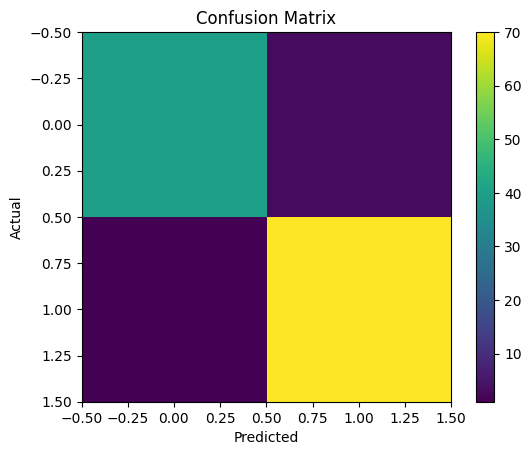

In [16]:
cm = confusion_matrix(y_test, y_pred)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.show()

### PCA Visualization

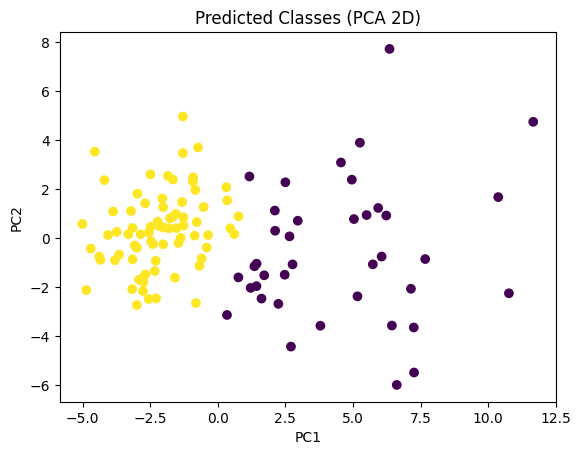

In [17]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y, test_size=0.2, random_state=42
)

model_pca = GaussianBayes()
model_pca.fit(X_train_pca, y_train_pca)

y_pred_pca = model_pca.predict(X_test_pca)

plt.figure()
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred_pca)
plt.title("Predicted Classes (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

### Decision Boundary

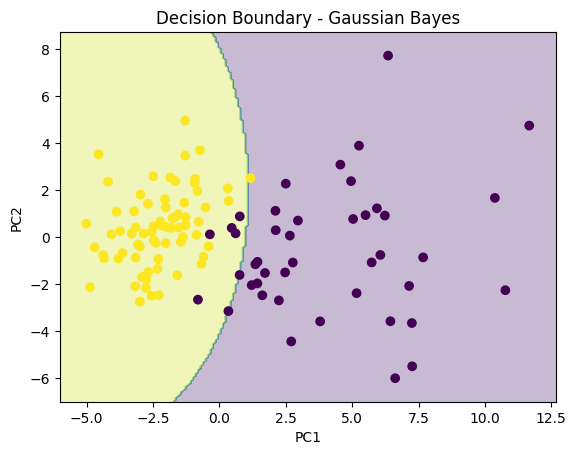

In [18]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min()-1, X[:, 0].max()+1
    y_min, y_max = X[:, 1].min()-1, X[:, 1].max()+1

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )

    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.title("Decision Boundary - Gaussian Bayes")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

plot_decision_boundary(model_pca, X_test_pca, y_test_pca)

### STEP 6: Visualize Feature Distribution (Gaussian Assumption)

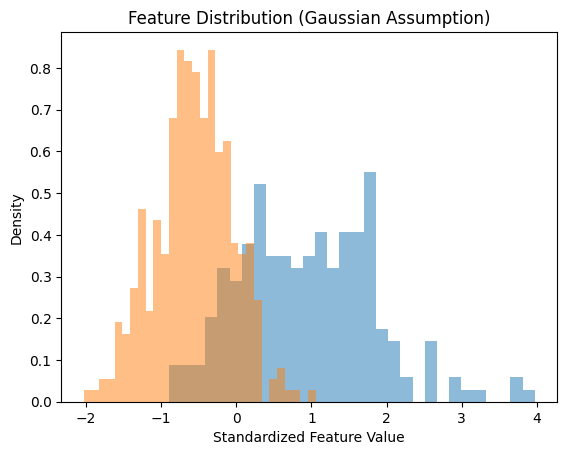

In [20]:
feature_index = 0  # first feature

plt.figure()

for c in np.unique(y):
    X_c = X[y == c]
    plt.hist(X_c[:, feature_index], bins=30, alpha=0.5, density=True)

plt.title("Feature Distribution (Gaussian Assumption)")
plt.xlabel("Standardized Feature Value")
plt.ylabel("Density")
plt.show()

### STEP 7: ROC Curve Visualization

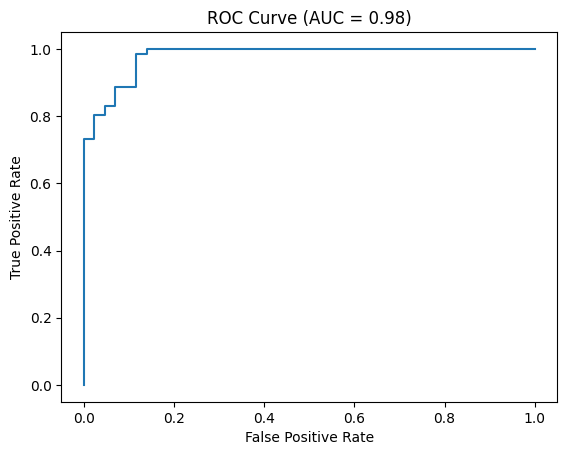

In [21]:
from sklearn.metrics import roc_curve, auc

# For binary classification use posterior of class 1
probs = []

for x in X_test:
    prior = np.log(model.prior[1])
    conditional = np.sum(np.log(model.gaussian_pdf(1, x)))
    probs.append(prior + conditional)

fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr)
plt.title("ROC Curve (AUC = %.2f)" % roc_auc)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()